# Display Inline/Crossline Section and Time Slice


## Load seismic data

Let's first load the seismic data used in "Tutorial 01 Read and Write SEG-Y File".


In [1]:
import os
from segyreader import readSegy

ROOT = 'F:/Github/Programming-Geophysics-in-Python/Datasets'
segy_file = os.path.join(ROOT,'F3/f3_seismic.sgy')

print('Reading SEG-Y file in process...')
traces, volume_header, trace_header = readSegy(segy_file)
print('Reading SEG-Y file completed[OK]\n.')

ns, ntr = traces.shape
print('Total number of traces:      ', ntr)
print('Number of samples per trace: ', ns)

dt = volume_header['dt']/1e6 # unit is seconds
print('Sampling rate:               ', dt, 's')


Reading SEG-Y file in process...
600515 record read.
Reading SEG-Y file completed[OK]
.
Total number of traces:       600515
Number of samples per trace:  463
Sampling rate:                0.004 s


## Display inline/crossline section

Let's firstly retieve the inline/crossline information from trace header. Secondly, we map the survey to see if it's a rectangular or with irregular shape


In [2]:
inlines = trace_header['FieldRecord']
xlines = trace_header['cdp']
sx = trace_header['SourceX']
sy = trace_header['SourceY']

print('Inline range:        ', inlines.min(), ' - ', inlines.max())
print('Crossline range:     ', xlines.min(), ' - ', xlines.max())
print('X-coordinate range:  ', sx.min(), ' - ', sx.max())
print('Y-coordinate range:  ', sy.min(), ' - ', sy.max())

Inline range:         100  -  750
Crossline range:      300  -  1250
X-coordinate range:   6054167  -  6295763
Y-coordinate range:   60735564  -  60904632


<IPython.core.display.Javascript object>


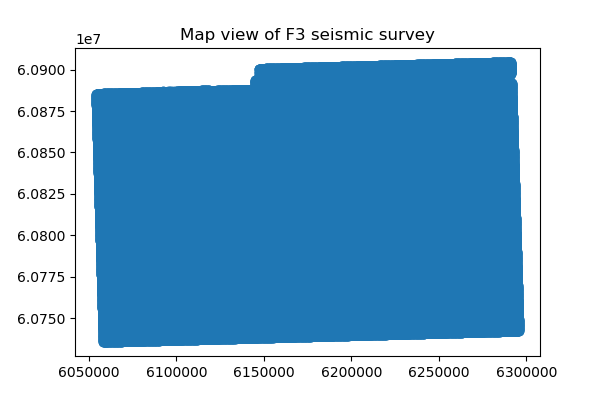

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.scatter(sx, sy)
ax.set_title('Map view of F3 seismic survey')
plt.show()

Now we can see this survey has irregular shape. Let's extract the seismic section along Inline 425.

<IPython.core.display.Javascript object>


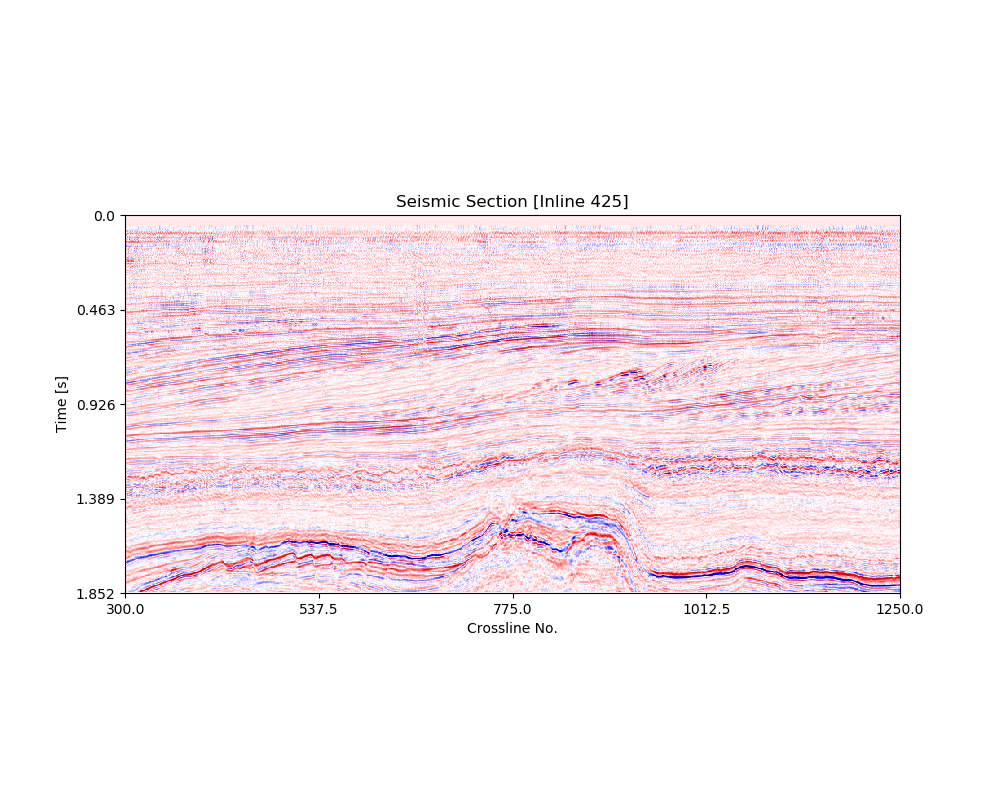

In [4]:
import numpy as np

# find trace indices that belong to Inline 425
inds = np.where(inlines == 425)[0]

# extract traces

section = traces[:, inds]

# for plot ticks and labels
xls = xlines[inds]
xticks = np.linspace(0, len(xls), 5)
xlabels = np.linspace(xls.min(), xls.max(), 5).astype('str')
t = np.arange(0,dt * ns + dt, dt)
yticks = np.linspace(0, len(t), 5)
ylabels = np.linspace(0, t.max(),5).astype('str')

# plot seismic section
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.imshow(section, cmap = 'seismic') # 'seismic' or 'gray'
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels.tolist())
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels.tolist())
ax.set_xlabel('Crossline No.')
ax.set_ylabel('Time [s]')
ax.set_title('Seismic Section [Inline 425]')
plt.show()

## Display time slice

To display a time slice, one needs to define the Inline-Crossline ranges and time value in order to extract the data values from trace data.

Here we firstly set these parameters as follows:

In [5]:
il_range = [200, 600] # inline range
xl_range = [600, 1000] # xline range
z = 1000 # time value, unit is ms

Next, we write a helper function to extract the time slice data and store it in a Numpy array.

In [6]:
# helper func
import numpy as np
def find_commons(aa, bb):

    a = aa.copy()
    b = bb.copy()   

    commons = set(a)&set(b)            

    sorter = np.argsort(aa)
    a_inds = sorter[np.searchsorted(aa, np.array(list(commons)), sorter=sorter)]
   
    sorter = np.argsort(bb)
    b_inds = sorter[np.searchsorted(bb, np.array(list(commons)), sorter=sorter)]

    
    return a_inds, b_inds


In [7]:
def extractSlice(data, th, il_range, xl_range, nsample):
    
    inlines = th['FieldRecord']
    xlines = th['cdp']
    
    # find out all inline indices and xline indices that are located within ranges
    il_indices =  np.where((inlines >= il_range[0]) & (inlines<= il_range[1]))[0]
    xl_indices =  np.where((xlines >= xl_range[0]) & (xlines<= xl_range[1]))[0]
    
   
    # find out all indices of inline-xline pair
    il_inds, xl_inds = find_commons(il_indices, xl_indices)
    
    # get the inds of inline-xline pair
    inds = il_indices[il_inds]
    
    # get all traces that of inline-xline pair
    traces = data[:, inds] # 1D numpy array
    
    # get the slice data as 2D numpy array
    nil = il_range[1] - il_range[0] + 1 # number of inlines
    nxl = xl_range[1] - xl_range[0] + 1 # number of xlines
    
    slices = traces[nsample, :].reshape(nil, nxl)
    
    return slices 
    

In [8]:
nsample = int(np.floor(z/(dt*1000))) # calc which sample point to extract according to given time value in microsecond
print('Sampling point to be extracted at: ', nsample)
slices = extractSlice(traces, trace_header, il_range, xl_range, nsample)

Sampling point to be extracted at:  250


<IPython.core.display.Javascript object>


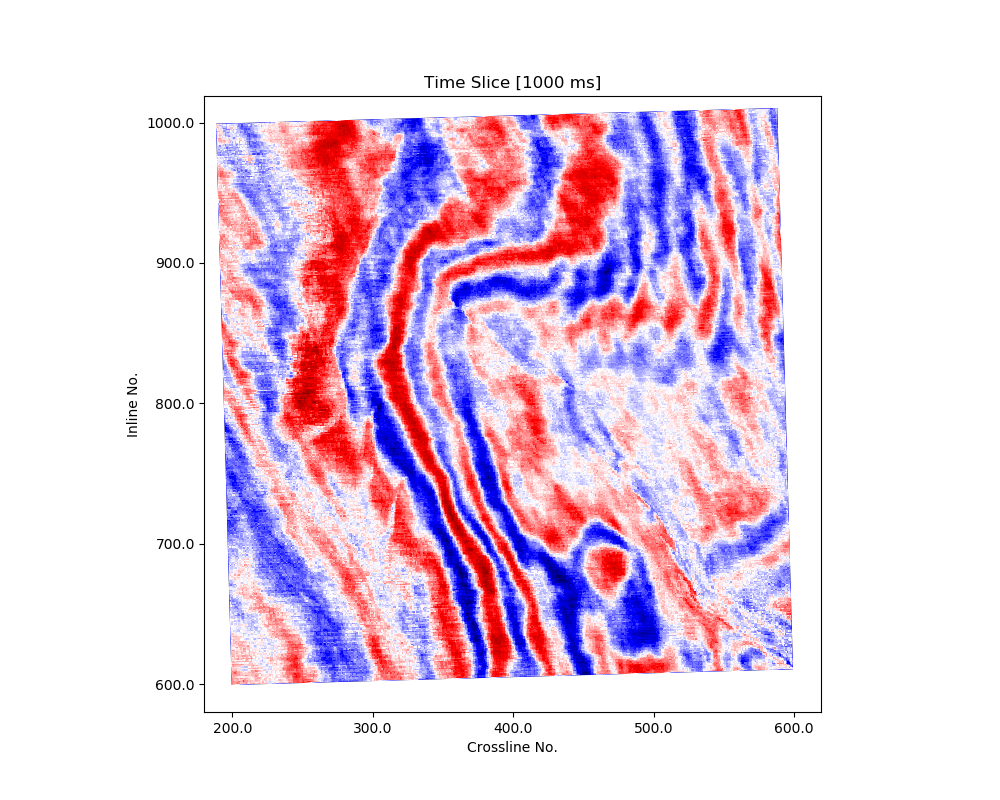

In [9]:

# for plot ticks and labels
nil, nxl = slices.shape

xticks = np.linspace(0, nil, 5)
xlabels = np.linspace(il_range[0], il_range[1], 5).astype('str')
yticks = np.linspace(0, nxl, 5)
ylabels = np.linspace(xl_range[0], xl_range[1], 5).astype('str')

# plot seismic section
fig, ax = plt.subplots(1,1, figsize=(10, 8))
im = ax.imshow(slices, cmap = 'seismic') # 'seismic' or 'gray'
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels.tolist())
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels.tolist())
ax.set_xlabel('Crossline No.')
ax.set_ylabel('Inline No.')
ax.set_title('Time Slice [1000 ms]')
ax.invert_yaxis()
plt.show()


Sometimes, the diretion of inline or crossline is not aligned to the geographic East-West or North-East. In this case, the map view of F3 seismic survey shows that this the time slice needs to be rotated by a few degrees in order to make the slice be correctly displayed.

The rotation needs the following steps:
1. get the bottom left and top right points coordinates
2. calculate azimuth of the line formed by the bottom left and top right points
3. calculate the rotation angle (in radian degree) in anti-clockwise
4. rotate per the angle with using Matplotlib transform

To implement the worflow defined above, let's define some helper functions.

In [10]:
from math import atan2, pi, degrees, radians

def azimuth(x1,y1,x2,y2):

    degBearing = degrees(atan2((x2 - x1),(y2 - y1)))
    if (degBearing < 0):
        degBearing += 360.0
    return radians(degBearing)

def coordinate(th, il, xl):
    
    inlines = th['FieldRecord']
    xlines = th['cdp']
    
    # find out all inline indices and xline indices that are located within ranges
    il_indices =  np.where(inlines == il)[0]
    xl_indices =  np.where(xlines == xl)[0]
    
   
    # find out all indices of inline-xline pair
    il_inds, xl_inds = find_commons(il_indices, xl_indices)
    
    # get the inds of inline-xline pair
    ind = il_indices[il_inds]
    
    sx = th['SourceX']
    sy = th['SourceY']
    
    x = sx[ind]
    y = sy[ind]
    
    return x, y
    
    

In [11]:
x_bl, y_bl = coordinate(trace_header, il_range[0], xl_range[0]) # coordinate of bottom left point
x_tr, y_tr = coordinate(trace_header, il_range[1], xl_range[1]) # coordinate of top right point

azi = azimuth(x_bl, y_bl, x_tr, y_tr) # azimuth of the diagonal line of the survey
theta = abs(azi-pi/4) # rotation angle in radian degree, anti-clockwise 
print('Rotation angle in radian degree: ', theta)

Rotation angle in radian degree:  0.027918774682583303


Now we have the rotation angle, let's use Matplotlib transformation functions to rotate the slice. 

In [12]:
import matplotlib.transforms as mtransforms

transform = mtransforms.Affine2D().rotate_around(0, 0,theta)
trans_data = transform + ax.transData
im.set_transform(trans_data)

ax.set_xlim([-20,420])
ax.set_ylim([-20,420])

(-20, 420)